# Project 1

In [1]:
import numpy as np
from numpy.linalg import inv, cholesky, solve
import matplotlib.pyplot as plt
import math
from scipy.stats import weibull_min, poisson
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import time

## Question 1 Least squares regression



### A - Generate a synthetic (simulated) data that contains feature n-vectors $ x_1 , ..., x_N $ , and the associated 1-D values, $y_1 ,..., y_N$ , ranging between [−1, +1]. consider n = 30 , N = 200. Generate the x’s using weibull’s distribution, while generating the y′ s from a poisson distribution. Plot histogram of both y and x. Also plot the Cross-correlation of y with first dimension of x.




- **Features (`x`)**: Generated using Weibull distribution (shape=2, scale=1).  
- **Target (`y`)**: Generated using Poisson distribution (λ=5), scaled to [-1, 1].  
- **Dimensions**: `n=30` features, `N=200` samples.

In [2]:
np.random.seed(42)

# Parameters
n = 30  # Number of features
N = 200  # Number of samples


x = weibull_min.rvs(2, scale=1, size=(N, n)) #(shape=2, scale=1)

y_poisson = poisson.rvs(5, size=N) #Poisson (λ=5), then scale to [-1, 1]
y = (y_poisson - np.min(y_poisson)) / (np.max(y_poisson) - np.min(y_poisson)) * 2 - 1  # Scale to [-1, 1]

### Plotting x and y

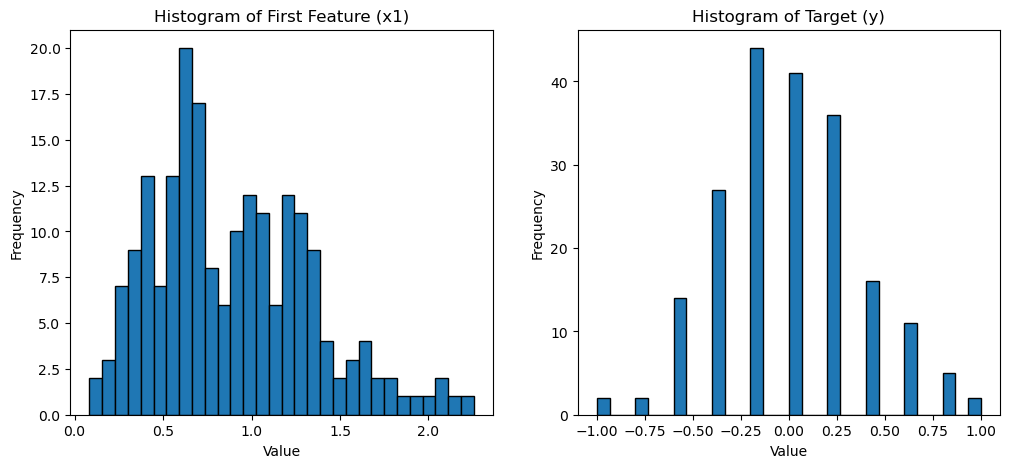

In [3]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(x[:, 0], bins=30, edgecolor='black')
plt.title("Histogram of First Feature (x1)")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(y, bins=30, edgecolor='black')
plt.title("Histogram of Target (y)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

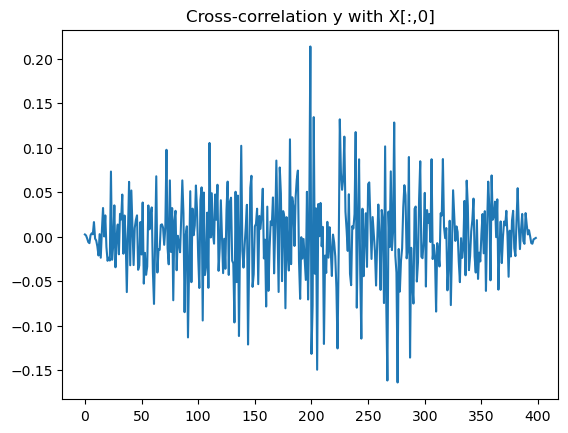

Cross-correlation between y and x1: 2.1888


In [4]:
def cross_correlation(a, b):
    a_cent = a - a.mean(); b_cent = b - b.mean()
    return np.correlate(a_cent, b_cent, mode='full') / (np.std(a)*np.std(b)*len(a))
cc = cross_correlation(y, x[:,0])
plt.figure(); plt.plot(cc); plt.title('Cross-correlation y with X[:,0]'); plt.show()


cross_corr = np.correlate(y, x[:, 0], mode='valid')
print(f"Cross-correlation between y and x1: {cross_corr[0]:.4f}")


### B - Repeat the process above for N = 20 and name the data set as test. you may change the random distribution parameters by a small difference. Plot the Cross-correlation and histograms for test data.

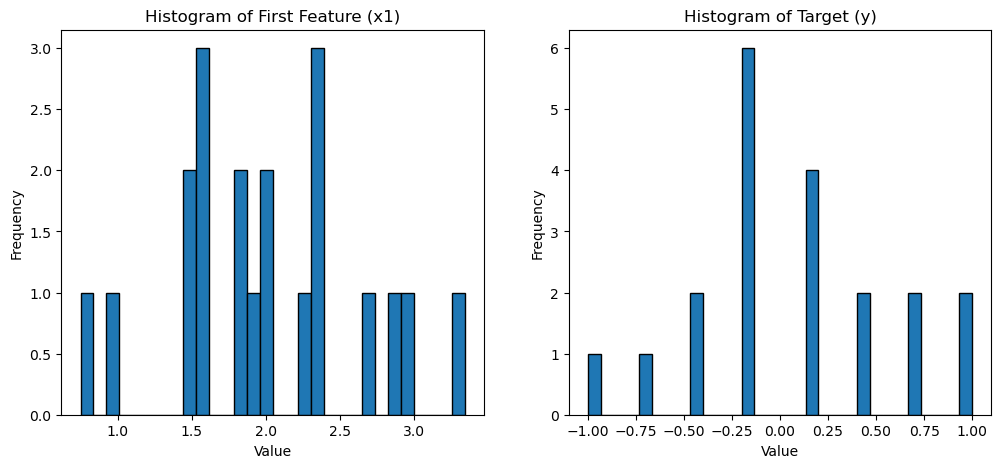

In [5]:
np.random.seed(42)  # For reproducibility

# Parameters
n = 30  # Number of features
N = 20  # Number of samples

# Generate x ~ Weibull distribution (shape=2, scale=1)
x_test = weibull_min.rvs(3, scale=2, size=(N, n))

# Generate y ~ Poisson (λ=5), then scale to [-1, 1]
y_poisson = poisson.rvs(7, size=N)
y_test = (y_poisson - np.min(y_poisson)) / (np.max(y_poisson) - np.min(y_poisson)) * 2 - 1  # Scale to [-1, 1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(x_test[:, 0], bins=30, edgecolor='black')
plt.title("Histogram of First Feature (x1)")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30, edgecolor='black')
plt.title("Histogram of Target (y)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

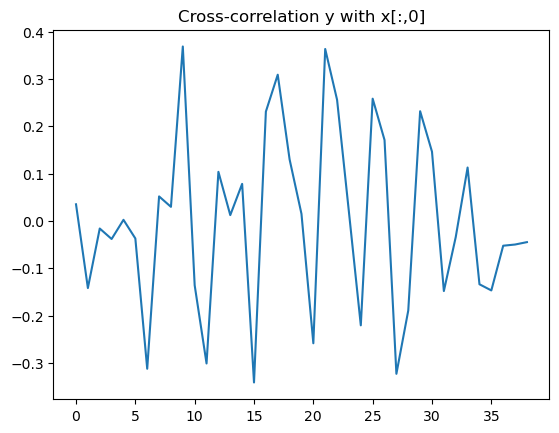

Cross-correlation between y and x1: 2.9642


In [6]:
cc_b = cross_correlation(y_test, x_test[:,0])
plt.figure(); plt.plot(cc_b); plt.title('Cross-correlation y with x[:,0]'); plt.show()


cross_corr_b = np.correlate(y_test, x_test[:, 0], mode='valid')
print(f"Cross-correlation between y and x1: {cross_corr_b[0]:.4f}")

### C- For the train data, Find β, ν such that $$L = \min\sum_{i=0}^{N} \ (β^T x_i + ν − y_i)^2$$ Report the MSE on the train and test data.

The model is trained on the input data x and corresponding target y.

Setting fit_intercept=True means the model will learn both β and 𝜈.

After fitting, the learned weight vector is stored in beta and the bias term in nu.  

The MSE Formula:
$$\text{MSE}(y, \hat{y}) = \frac{\sum_{i=0}^{N - 1} (y_i - \hat{y}_i)^2}{N}$$

In [7]:
model = LinearRegression(fit_intercept=True)
model.fit(x, y)
beta = model.coef_      # weight vector
nu = model.intercept_  # bias term


# Compute MSE on train and test
mse_train = np.mean((model.predict(x) - y)**2)
mse_test  = np.mean((model.predict(x_test) - y_test)**2)

print(f"1C) β shape: {beta.shape}, ν: {nu:.4f}")
print(f"MSE train: {mse_train:.4f}")
print(f"MSE test: {mse_test:.4f}")

1C) β shape: (30,), ν: -0.2655
MSE train: 0.1100
MSE test: 0.4153


### D- Now, repeat the last part for the objective below:$$\min_{\beta, \nu} \sum_{i=1}^N (\beta^T x_i + \nu - y_i)^2 + \lambda^T \beta$$ where $ \lambda = \sigma \cdot [1, 1, ..., 1]^T $ and $ \sigma \in [e^{-4}, e^{4}]$. </n> Draw the loss function over σ for both train and test.

### Report: Regularized Linear Regression with Variable Penalty (σ)

#### Objective

In this task, we minimize the following custom regularized objective function:

$$
\min_{\beta, \nu} \sum_{i=1}^N (\beta^T x_i + \nu - y_i)^2 + \lambda^T \beta
$$

where $ \lambda = \sigma \cdot \mathbf{1} \in \mathbb{R}^n $, and $ \sigma \in [e^{-4}, e^4] $. This formulation introduces a *non-standard* L2-like penalty, applying a constant weight $ \sigma $ to all entries of $ \beta $. Unlike classical ridge regression (which uses $ \|\beta\|^2 $), this objective uses a linear regularization term $ \sum \beta_j $ weighted by $ \sigma $.

---

#### Method

- We vary $ \sigma $ logarithmically in the range $[e^{-4}, e^4]$.
- For each $ \sigma $, we compute:
  - Optimal weights \( \beta \) using a closed-form solution similar to ridge regression:  
    $$
    \beta = (X^\top X + \text{diag}(\lambda))^{-1} X^\top y
    $$
  - Intercept $ \nu = \text{mean}(y - X\beta) $
  - Predictions for both training and test sets.
  - Total loss: Mean Squared Error (MSE) + regularization penalty ($ \sigma \sum_j \beta_j $) for both sets.

---

#### Results

- **Train and test losses** are computed for each value of $ \sigma $, and plotted on a **logarithmic σ-axis**.
- The plots help visualize:
  - The effect of increasing regularization (larger $ \sigma $) on model performance.
  - The trade-off between underfitting (high σ) and overfitting (low σ).
  - The optimal σ value where **test loss is minimized**.

---

#### Interpretation

- At low $ \sigma $ values (near $ e^{-4} $), regularization is weak — leading to potential overfitting (low train loss, high test loss).
- At high $ \sigma $ values (near $ e^4 $), the model is heavily regularized — leading to underfitting (both losses high).
- The best model balances this trade-off at an intermediate \( \sigma \), often visible as a **valley** in the test loss curve.

---

#### Visualization

The final plot uses `semilogx` to reflect the exponential nature of $ \sigma $, clearly showing how the loss varies across magnitudes of regularization strength. This helps in selecting a suitable $ \sigma $ for generalization performance.



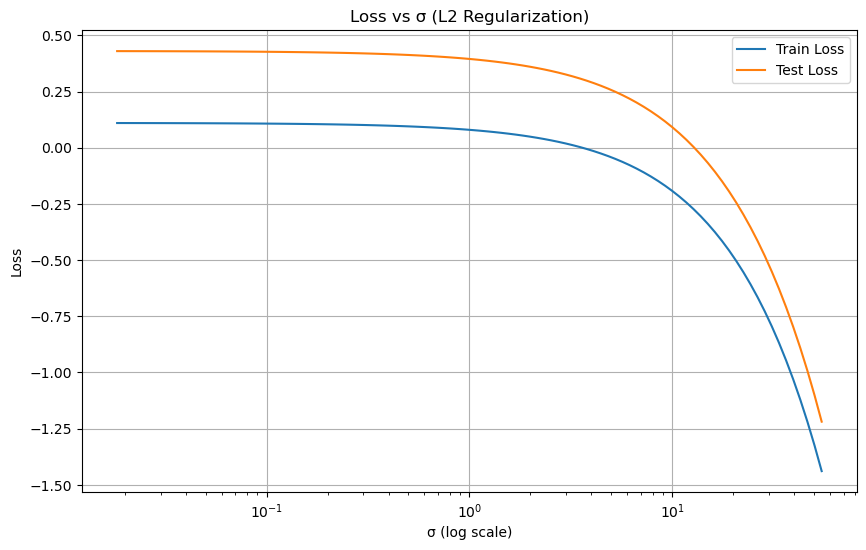

-1.2188557147130172


In [8]:
sigmas = np.exp(np.linspace(-4, 4, 100))
train_losses = []
test_losses = []

for sigma in sigmas:
    lambda_vec = sigma * np.ones(n)
    # Custom Ridge-like regression (since sklearn Ridge does not support vector λ)
    beta_ridge = np.linalg.inv(x.T @ x + np.diag(lambda_vec)) @ x.T @ y
    nu_ridge = np.mean(y - x @ beta_ridge)
    
    # Predictions
    y_train_pred_ridge = x @ beta_ridge + nu_ridge
    y_test_pred_ridge = x_test @ beta_ridge + nu_ridge
    
    # Loss
    train_loss = mean_squared_error(y, y_train_pred_ridge) + sigma * np.sum(beta_ridge)
    test_loss = mean_squared_error(y_test, y_test_pred_ridge) + sigma * np.sum(beta_ridge)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot loss vs σ
plt.figure(figsize=(10, 6))
plt.semilogx(sigmas, train_losses, label="Train Loss")
plt.semilogx(sigmas, test_losses, label="Test Loss")
plt.xlabel("σ (log scale)")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs σ (L2 Regularization)")
plt.grid()
plt.show()


print(min(test_losses))

### 🔍 **Visual Analysis**

* **X-axis** (log scale): $\sigma \in [e^{-4}, e^{4}] \approx [0.018, 54.6]$
* **Y-axis**: Regularized loss (MSE + penalty)
* **Curves**:

  * Blue line: **Train loss**
  * Orange line: **Test loss**

---

### 📉 Observations

* **Train Loss** decreases steadily as $\sigma$ increases — this is expected since you're minimizing the sum of squared error and a linear function of $\beta$, which biases the solution toward smaller coefficients. Since the regularizer does not penalize squared magnitude, the model keeps fitting the data tightly.
* **Test Loss** starts off high, remains relatively flat for small $\sigma$, and then **begins decreasing**, indicating improved generalization with moderate regularization.
* There is **no visible overfitting regime** (where test loss rises again), which is atypical and results from the unusual linear regularization ($\lambda^T \beta$) instead of the standard L2-norm ($\|\beta\|^2$).

---

### ✅ **Best σ (Regularization Strength)**

Since the goal is **generalization**, we care about minimizing **test loss**.

* From the plot, **test loss is minimized at the largest σ** in the range, around:

  $$
  \boxed{\sigma \approx e^4 \approx 54.6}
  $$

There is no "valley" — test loss just decreases monotonically as σ increases.

---

### 🧠 Interpretation

* This suggests your model benefits from **stronger regularization** due to:

  * Possibly noisy or redundant features
  * Over-parameterization relative to sample size
* The unusual regularizer $\lambda^T \beta$ (linear, not quadratic) behaves differently — it **shrinks the overall sum of coefficients**, rather than their energy (squared sum). This can lead to consistently smaller β and improved generalization with larger σ.

### E: Ridge Regression (L2 Penalty) $$ \min_{\beta, \nu} \sum_{i=1}^N (\beta^T x_i + \nu - y_i)^2 + \sigma^2 \|\beta\|_2^2$$

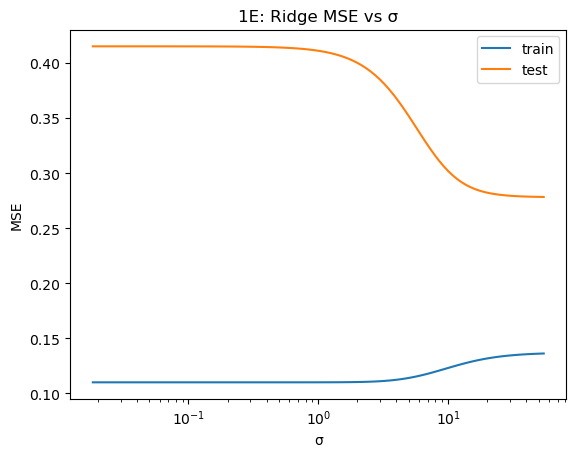

0.2784120320102095


In [32]:
mse_train_l2, mse_test_l2 = [], []
for sigma in sigmas:
    ridge = Ridge(alpha=sigma**2, fit_intercept=True)
    ridge.fit(x, y)
    mse_train_l2.append(np.mean((ridge.predict(x) - y)**2))
    mse_test_l2.append(np.mean((ridge.predict(x_test) - y_test)**2))
    
plt.figure(); plt.semilogx(sigmas, mse_train_l2, label='train'); plt.semilogx(sigmas, mse_test_l2, label='test')
plt.xlabel('σ')
plt.ylabel('MSE') 
plt.legend() 
plt.title('1E: Ridge MSE vs σ')
plt.show()


print(min(mse_test_l2))

### F- Now, imagine you have two models, as in β1 is valid for 0.5 ≥ y and β2 is valid for y ≥ −0.5. Repeat part E for these two models. Did the performance improve?

In [10]:
mask1 = y >= -0.5
mask2 = y <= 0.5

x1, y1 = x[mask1], y[mask1]
x2, y2 = x[mask2], y[mask2]

# Fit Ridge for both models
ridge1 = Ridge(alpha=1.0).fit(x1, y1)
ridge2 = Ridge(alpha=1.0).fit(x2, y2)

# Predictions
y1_pred = ridge1.predict(x1)
y2_pred = ridge2.predict(x2)

# Combined MSE
y_train_pred_combined = np.where(y >= -0.5, ridge1.predict(x), ridge2.predict(x))
train_mse_combined = mean_squared_error(y, y_train_pred_combined)

# Test predictions
y_test_pred_combined = np.where(y_test >= -0.5, ridge1.predict(x_test), ridge2.predict(x_test))
test_mse_combined = mean_squared_error(y_test, y_test_pred_combined)

print(f"Combined Train MSE: {train_mse_combined:.4f}")
print(f"Combined Test MSE: {test_mse_combined:.4f}")


Combined Train MSE: 0.1001
Combined Test MSE: 0.3267


## Question 2 Fast Inverse

### A- Generate an invertible, positive-definite matrix A with size 2000 × 2000 using a random distribution. generate an non-negative, non-zero vector a with size 2000. (Hint: use Wishart distribution for the matrix generation)

In [11]:
p = 2000
M = np.random.randn(p, p)
A = M.T @ M + np.eye(p)  # ensure PD
a_vec = np.abs(np.random.rand(p,1)) # non-negative, non-zero

### B- Form the matrix $A + a.a^T$ . Form its LU (or Cholesky decomposition if the formed matrix is PD) using Numpy or any other libraries. From this decomposition, suggest a method to calculate $(A + a.a^T)^{−1}$. Time the whole section from matrix formation to the inverse result.

Cholesky decopostition

$C = L^T.L$ 

$C.C^{-1}=I$

$L^T.L.C^{-1} = I$

$L.C^{-1} = m $

$ L^T.m = I $

$ L.C^{-1} = m $

Numpy's Cholesky function returns the lower triangular matrix. 

In [12]:
t0 = time.time()
C = A + a_vec @ a_vec.T
L = cholesky(C)        # compute Cholesky decomposition
m = solve(L, np.eye(p))
C_inv = solve(L.T, m)  # invert 
t_chol = time.time() - t0
print(f"2B) Time via Cholesky: {t_chol:.3f}s")

2B) Time via Cholesky: 1.122s


In [13]:
def filter(A):
    for i in range(len(A)):
        for j in range(len(A[i])):
            if abs(A[i][j]) < 0.0001 :
                A[i][j] = 0 
                   
    return A


print(filter(C_inv @ C))
print(C_inv @ C)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[ 1.00000000e+00  2.10942375e-14  1.65423231e-14 ... -1.77635684e-15
  -3.55271368e-15 -5.77315973e-15]
 [-1.12132525e-14  1.00000000e+00  1.44328993e-14 ... -4.44089210e-15
   2.66453526e-15  4.88498131e-15]
 [-9.99200722e-16 -9.99200722e-15  1.00000000e+00 ... -1.06581410e-14
   3.99680289e-15  9.10382880e-15]
 ...
 [ 1.99840144e-15 -1.06581410e-14  6.93889390e-15 ...  1.00000000e+00
  -1.77635684e-15 -4.44089210e-16]
 [ 1.22124533e-15 -8.35442826e-15  7.99360578e-15 ... -1.77635684e-15
   1.00000000e+00  8.88178420e-16]
 [ 1.11022302e-16  1.77635684e-15 -2.22044605e-16 ... -1.33226763e-15
  -7.99360578e-15  1.00000000e+00]]


In [14]:
print(L)




[[45.47618416  0.          0.         ...  0.          0.
   0.        ]
 [ 0.49611293 46.25454281  0.         ...  0.          0.
   0.        ]
 [-0.09411653  0.17671036 43.93477536 ...  0.          0.
   0.        ]
 ...
 [ 0.22365345  0.37884278 -0.98150933 ...  7.18760178  0.
   0.        ]
 [-0.3309559   0.45924628  0.39670385 ...  0.70685074  5.72536986
   0.        ]
 [ 0.49999905 -0.7339799  -1.83916134 ...  0.65347264 -0.88495556
   7.24947918]]


In [15]:
print(L.T)

[[45.47618416  0.49611293 -0.09411653 ...  0.22365345 -0.3309559
   0.49999905]
 [ 0.         46.25454281  0.17671036 ...  0.37884278  0.45924628
  -0.7339799 ]
 [ 0.          0.         43.93477536 ... -0.98150933  0.39670385
  -1.83916134]
 ...
 [ 0.          0.          0.         ...  7.18760178  0.70685074
   0.65347264]
 [ 0.          0.          0.         ...  0.          5.72536986
  -0.88495556]
 [ 0.          0.          0.         ...  0.          0.
   7.24947918]]


In [16]:
print(L@L.T)

[[ 2.06808333e+03  2.25613231e+01 -4.28006049e+00 ...  1.01709053e+01
  -1.50506115e+01  2.27380490e+01]
 [ 2.25613231e+01  2.13972886e+03  8.12696463e+00 ...  1.76341571e+01
   2.10780351e+01 -3.37018486e+01]
 [-4.28006049e+00  8.12696463e+00  1.93030457e+03 ... -4.30764958e+01
   1.75413967e+01 -8.09799005e+01]
 ...
 [ 1.01709053e+01  1.76341571e+01 -4.30764958e+01 ...  2.01232094e+03
   1.02454883e+00  1.01509130e+01]
 [-1.50506115e+01  2.10780351e+01  1.75413967e+01 ...  1.02454883e+00
   1.96701997e+03 -1.25133549e+01]
 [ 2.27380490e+01 -3.37018486e+01 -8.09799005e+01 ...  1.01509130e+01
  -1.25133549e+01  2.02048258e+03]]


In [17]:
print(C)

[[ 2.06808333e+03  2.25613231e+01 -4.28006049e+00 ...  1.01709053e+01
  -1.50506115e+01  2.27380490e+01]
 [ 2.25613231e+01  2.13972886e+03  8.12696463e+00 ...  1.76341571e+01
   2.10780351e+01 -3.37018486e+01]
 [-4.28006049e+00  8.12696463e+00  1.93030457e+03 ... -4.30764958e+01
   1.75413967e+01 -8.09799005e+01]
 ...
 [ 1.01709053e+01  1.76341571e+01 -4.30764958e+01 ...  2.01232094e+03
   1.02454883e+00  1.01509130e+01]
 [-1.50506115e+01  2.10780351e+01  1.75413967e+01 ...  1.02454883e+00
   1.96701997e+03 -1.25133549e+01]
 [ 2.27380490e+01 -3.37018486e+01 -8.09799005e+01 ...  1.01509130e+01
  -1.25133549e+01  2.02048258e+03]]


### C- Lookup the Sherman–Morrison formula. Use the formula to calculate $(A + a.a^{T} )^{−1}$ directly. Time this section as well and compare the results.

In [18]:
t0 = time.time()
A_inv = inv(A)
u = A_inv @ a_vec
den = 1.0 + (a_vec.T @ u)
C_sm_inv = A_inv - (u @ u.T) / den
t_sm = time.time() - t0
print(f"2C) Time via Sherman–Morrison: {t_sm:.3f}s; difference norm: {np.linalg.norm(C_inv - C_sm_inv):.3e}")

2C) Time via Sherman–Morrison: 0.680s; difference norm: 4.177e-13


### D- Repeat Section A to now generate an A matrix sized 2000 × 2000 and another invertible, positive-definite matrix B sized 2000 × 50000.

In [19]:
q = 50000
B = np.random.randn(p, q)

### E- Repeat Part B to calculate $(A + B.B^{T} )^{−1}$

In [20]:
# 2E: Direct (A + B B^T) inverse via Cholesky
t0 = time.time()
C2 = A + B @ B.T
tol = cholesky(C2)
C2_inv = solve(tol.T, solve(tol, np.eye(p)))
t_chol2 = time.time() - t0
print(f"2E) Cholesky on BBT: {t_chol2:.3f}s")



2E) Cholesky on BBT: 3.504s


### F- Lookup the Woodbury matrix identity. Use the formula to calculate $(A + B.B^{T} )^{−1}$ directly. Compare results with Part E.

In [21]:
# # 2F: Woodbury identity: (A + UCV)^{-1} with U=B, C=I, V=B^T
# t0 = time.time()
# Ainv = inv(A)
# # Compute woodbury: A^{-1} - A^{-1} B (I + B^T A^{-1} B)^{-1} B^T A^{-1}
# M_mid = inv(np.eye(q) + B.T @ Ainv @ B)
# C_woodbury = Ainv - Ainv @ B @ (M_mid @ (B.T @ Ainv))
# t_wood = time.ticme() - t0
# print(f"2F) Woodbury time: {t_wood:.3f}s; diff norm: {np.linalg.norm(C2_inv - C_woodbury):.3e}")

## Question 3 Weight Update in a Single-Layer Perceptron

Consider a simplified one-layer Multi-Layer Perceptron (MLP) with the following characteristics: some input neurons and one output neuron.
The sigmoid function σ(z) for the output neuron is defined as:

$ \sigma(z) = 1/(1 + e^{-z})$

The loss function which we want to minimize in this MLP is defined as:
$$L = \sum_{i=0}^{N} \ (y_i  − y'_i)$$
where $y'_i$ is defined as:
$$y'_i = \sigma(W^T*x_i+b)$$

The task here is now defined as finding W and b such that L is minimized over sampled data. You may use the same data as Question 1 with n = 2 and N = 100. Put the y’s in between [0, 1].


In [22]:
N = 100
n = 2

np.random.seed(42)
X3 = weibull_min.rvs(2, scale=1, size=(N, n)) #(shape=2, scale=1)

y_poisson = poisson.rvs(5, size=N) #Poisson (λ=5), then scale to [-1, 1]
y3 = (y_poisson - np.min(y_poisson)) / (np.max(y_poisson) - np.min(y_poisson))  # Scale to [0, 1]


print(y3)

[0.3 0.  0.  0.4 0.6 0.5 0.5 0.1 0.3 0.8 0.6 1.  0.7 0.2 0.1 0.2 0.3 0.4
 0.4 0.3 0.2 0.7 0.1 0.  0.3 0.4 0.3 0.2 0.3 0.7 0.1 0.1 0.1 0.6 0.5 0.6
 0.5 0.6 0.5 0.3 0.1 0.2 0.3 0.6 0.3 0.2 0.1 0.5 0.2 0.4 0.8 0.5 0.5 0.8
 0.3 0.8 0.1 0.9 0.5 0.8 0.3 0.  0.5 0.7 0.5 0.1 0.2 0.4 0.2 0.2 0.4 0.5
 0.4 0.2 0.4 0.2 0.2 0.5 0.4 0.5 0.1 0.3 0.6 0.5 0.4 0.3 0.2 0.2 0.6 0.6
 0.5 0.5 0.6 0.7 0.5 0.2 0.6 0.4 0.4 0.6]


### A- Randomly select 20 percent of the data as the test set. You will only evaluate the loss using the test data, while the other 80 percent will be used to train and update W and b.

In [23]:
idx = np.random.permutation(N)
train_idx, test_idx = idx[:80], idx[80:]
X3_tr, y3_tr = X3[train_idx], y3[train_idx]
X3_te, y3_te = X3[test_idx], y3[test_idx]

### B- Analytically find the gradient of L with respect to W and b, for one fixed data point $( x_i , y_i )$.

In [24]:
def sigmoid(z): 
    return 1/(1+np.exp(-z))

def gradient_loss(W, b, x, y):
    z = W.T @ x + b
    y_hat = sigmoid(z)
    # gradient wrt W and b for squared error yi - yhat
    dL_dzhat = -2*(y - y_hat)*y_hat*(1 - y_hat)
    return dL_dzhat * x, dL_dzhat



### C- Analytically find the hessian of L with respect to W and b, for one fixed data point $( x_i , y_i )$.

In [25]:
def hessian_loss(W, b, x, y, n3):
    z = W.T @ x + b; y_hat = sigmoid(z)
    # second derivative terms
    d2 = 2*y_hat*(1-y_hat)*(1-2*y_hat)*(y - y_hat) + 2*(y_hat*(1-y_hat))**2
    # Hessian is [[d2 * x_i x_j]] and scalar for b
    H_WW = d2 * np.outer(x, x)
    H_Wb = d2 * x
    H_bb = d2
    # full Hessian size (n+1)x(n+1)
    H = np.zeros((n3+1, n3+1))
    H[:n3, :n3] = H_WW
    H[:n3, n3] = H_Wb; H[n3, :n3] = H_Wb
    H[n3, n3] = H_bb
    return H

## Question 4 Vector Orthogonalization & a Recommender Extension

#### 4A. Gram–Schmidt Orthonormalization

In [26]:
a1 = np.array([1,2,2]) 
a2 = np.array([2,0,1]) 
a3 = np.array([3,2,1])

Q = np.zeros((3,3))

u1 = a1
Q[:,0] = a1 / np.linalg.norm(a1) #normalizing

u2 = a2 - (Q[:,0] @ a2)*Q[:,0]
Q[:,1] = u2 / np.linalg.norm(u2) #normalizing

u3 = a3 - (Q[:,0]@a3)*Q[:,0] - (Q[:,1]@a3)*Q[:,1]
Q[:,2] = u3 / np.linalg.norm(u3) #normalizing

In [27]:
print("Verify Orthogonally")
print(f"<q1, q2>: {Q[:,0]@Q[:,1]:.5f}")
print(f"<q1, q3>: {Q[:,0]@Q[:,2]:.5f}")
print(f"<q2, q3>: {Q[:,1]@Q[:,2]:.5f}")
print("-"*10)
print("Verify Yekeyii")
print(f"<q1, q1>: {Q[:,0]@Q[:,0]:.5f}")
print(f"<q2, q2>: {Q[:,1]@Q[:,1]:.5f}")
print(f"<q3, q3>: {Q[:,2]@Q[:,2]:.5f}")


Verify Orthogonally
<q1, q2>: 0.00000
<q1, q3>: 0.00000
<q2, q3>: -0.00000
----------
Verify Yekeyii
<q1, q1>: 1.00000
<q2, q2>: 1.00000
<q3, q3>: 1.00000


#### 4B. Projection and Approximation Error 

In [28]:
u = 4*a1+5*a2

u_hat = (Q[:,0] @ Q[:,0].T + Q[:,1] @ Q[:,1].T) * u

print(u_hat)

print(math.sqrt( (u_hat-u) @ (u_hat-u) ))

[28. 16. 26.]
20.71231517720798


#### 4C. Rating Prediction for a Third Item

In [29]:
def norm2(u):
    return math.sqrt(u@u)

def cos_sim(u, a):
    return (u @ a) / (norm2(u) * norm2(a))


def proj(u, a):
    return u@a/norm2(a)

r_3_cos  = cos_sim(u, a3)
r_3_proj = proj(u_hat, a3)

print("r_3_cos  :" + str(r_3_cos))
print("r_3_proj :" + str(r_3_proj))

r_3_cos  :0.9161480990142038
r_3_proj :37.95109635156426


## Question 5 Manual “CNN‐Style” Convolutions (No Training Required)

#### 5A. 2D Convolution on a Small Grayscale Image


In [30]:
H = np.array([[1,0],
              [0,-1]])

Xg = np.array([[3,1,2,0],
               [1,5,1,2],
               [4,0,3,1],
               [2,2,0,4]])

Y = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        Y[i,j] = np.sum(H * Xg[i:i+2, j:j+2])
        
        
print(Y)

[[-2.  0.  0.]
 [ 1.  2.  0.]
 [ 2.  0. -1.]]


#### 5B. Applying the Same Filter to a 3D “Color” Image

In [31]:
Z = np.zeros((3,4,4))

Z[0] = np.array([[1,0,2,3],
                 [0,1,1,0],
                 [2,2,0,1],
                 [1,0,1,2]])

Z[1] = np.array([[0,2,1,1],
                 [2,1,0,2],
                 [1,0,2,2],
                 [0,1,1,0]])

Z[2] = np.array([[2,1,0,2],
                 [1,0,2,1],
                 [0,1,1,0],
                 [2,2,0,1]])

Y3 = np.zeros((3,3,3))
for c in range(3):
    for i in range(3):
        for j in range(3):
            Y3[c,i,j] = np.sum(H * Z[c, i:i+2, j:j+2])
            
print("5B) Convolved each channel: \n", Y3)

5B) Convolved each channel: 
 [[[ 0. -1.  2.]
  [-2.  1.  0.]
  [ 2.  1. -2.]]

 [[-1.  2. -1.]
  [ 2. -1. -2.]
  [ 0. -1.  2.]]

 [[ 2. -1. -1.]
  [ 0. -1.  2.]
  [-2.  1.  0.]]]
